# Data split
Split data by day and machine:
- 50 mesurments for 1 day
- 6 days for 1 machine

In [229]:
import json
import pandas as pd
import numpy as np
from utils import import_df
from matplotlib import pyplot as plt

df = import_df("3-noise-generation-output.json")

<IPython.core.display.Javascript object>

In [230]:
def get_days(df):
    df["day"] = 0
    df["machine"] = 0
    counter_measure = 0
    counter_day = 0
    counter_machine = 0
    for i, row in df.iterrows():
        if (counter_measure % 50) == 0:
            counter_measure = 0
            counter_day += 1
        if (counter_day % 7) == 0:
            counter_measure = 0
            counter_day = 1
            counter_machine += 1
        df.at[i, "day"] = counter_day
        df.at[i, "machine"] = counter_machine
        counter_measure += 1

    df["bearing"] = 0
    df.loc[df.label.isin(["bearings-1", "bearings-2"]), "bearing"] = 1

    df["magnet"] = 0
    df.loc[df.label == "magnet-partial", "magnet"] = 0.5
    df.loc[df.label == "magnet-1", "magnet"] = 0.7
    df.loc[df.label == "magnet-2", "magnet"] = 1

    df["electricity"] = 0
    df.loc[df.label == "magnet-2-nogrounding", "electricity"] = 1

    df["rotor"] = 0

    # df = df.drop("label", axis=1)
    return df


df = get_days(df)
df

,s_00,s_01,s_02,s_03,s_04,s_05,s_06,s_07,s_08,s_09,...,vib_z_peak,vib_z_vel,current,label,day,machine,bearing,magnet,electricity,rotor
0,-0.265235,-5.048122,-3.631346,-4.439543,-3.357498,-0.204776,-1.318228,-0.339534,-1.400015,-0.246901,...,0.817187,2.849615,3.974052,working-engine-1,1,0,0,0.0,0,0
1,1.803906,-7.633756,-5.389268,-1.570934,-2.791938,-1.642577,-1.893539,0.155088,-0.426586,0.362725,...,0.384010,0.855245,3.966374,working-engine-1,1,0,0,0.0,0,0
2,0.034944,-7.383289,-10.814815,-5.313512,-2.078825,-0.999530,-2.935479,-0.510686,-0.604878,-0.327708,...,0.764138,2.917843,3.971816,working-engine-1,1,0,0,0.0,0,0
3,-1.236713,-6.816264,-4.414403,-2.289054,-2.182520,-1.306811,-1.128795,0.227098,0.474560,-0.287856,...,0.668764,2.192881,3.963132,working-engine-1,1,0,0,0.0,0,0
4,-0.631867,1.805891,-4.057512,-3.777951,-4.524474,-0.794026,-2.293586,0.294561,-0.637668,-0.196524,...,0.354827,1.877270,3.961272,working-engine-1,1,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31795,1.621144,6.426994,2.831992,0.201274,-0.176498,0.919015,2.139039,0.051557,0.285876,-0.177516,...,0.995157,0.564188,3.933841,working-engine-2,6,105,0,0.0,0,0
31796,-0.753628,-2.764779,-0.148560,-2.216969,-0.432313,0.391412,0.198170,-0.161367,-0.208661,0.363186,...,0.851721,0.213766,3.946284,working-engine-2,6,105,0,0.0,0,0
31797,-0.224139,-1.600675,-2.785047,0.721778,0.588208,-0.655339,1.173323,-0.078556,-0.200729,-0.444910,...,1.033311,1.286546,3.932896,working-engine-2,6,105,0,0.0,0,0
31798,-1.836151,2.152550,-0.564253,0.057216,-0.133246,0.419357,-0.712477,-1.009656,1.032995,-0.294873,...,0.920297,0.808079,3.916539,working-engine-2,6,105,0,0.0,0,0


<IPython.core.display.Javascript object>

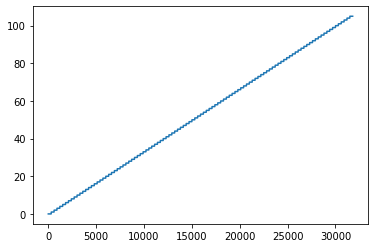

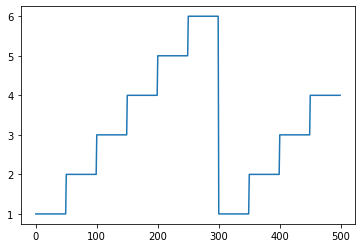

<IPython.core.display.Javascript object>

In [231]:
df.machine.plot()
plt.show()

df.day[:500].plot()
plt.show()

## Extract features
- RMS : root mean square
- variance
- skewness : normalised third central moment
- kurtosis : normalised fourth central moment
- normalised sixth central moment
- PV : peak value

In [232]:
def relevant_df(df, machine_id, label, day):
    data = df[(df.machine == machine_id) & (df.day == day)]
    data = data[label]
    return data


def mean(df, machine_id, data_label, day, **kwargs):
    mean = relevant_df(df, machine_id, data_label, day).mean()
    return mean


def rms(df, machine_id, data_label, day, **kwargs):
    s = relevant_df(df, machine_id, data_label, day) ** 2
    ms = s.mean()
    import math

    rms_ = math.sqrt(ms)
    return rms_


def variance(df, machine_id, data_label, day, **kwargs):
    values = relevant_df(df, machine_id, data_label, day)
    var = values.var()
    return var


def skewness(df, machine_id, data_label, day, **kwargs):
    skew = relevant_df(df, machine_id, data_label, day).skew()
    return skew


def kurtosis(df, machine_id, data_label, day, **kwargs):
    kur = relevant_df(df, machine_id, data_label, day).kurtosis()
    return kur


def max_value(df, machine_id, data_label, day, **kwargs):
    max = relevant_df(df, machine_id, data_label, day).max()
    return max


def quantile(df, machine_id, data_label, day, **kwargs):
    q = kwargs.get("quantile", 0.5)

    df = relevant_df(df, machine_id, data_label, day)
    quantile = df.quantile(q)
    return quantile


def interquantile_range(df, machine_id, data_label, day, **kwargs):
    low = kwargs.get("low", 0.25)
    high = kwargs.get("high", 0.75)

    q_low = quantile(df, machine_id, data_label, day, quantile=low)
    q_high = quantile(df, machine_id, data_label, day, quantile=high)
    iqr = q_high - q_low

    return iqr


def mean_absolute_deviation(df, machine_id, data_label, day, **kwargs):
    mad = relevant_df(df, machine_id, data_label, day).mad()
    return mad


def trimmed_mean(df, machine_id, data_label, day, **kwargs):
    trim = kwargs.get("trim", 0.1)
    df = relevant_df(df, machine_id, data_label, day)
    n = len(df)
    trim_index = int(n * trim)
    trimmed_df = df.iloc[trim_index:-trim_index]
    mean = trimmed_df.mean()
    return mean


def peak_value(df, machine_id, data_label, day, **kwargs):
    abs = relevant_df(df, machine_id, data_label, day).abs()
    peak = abs.max()
    return peak


def crest_factor(df, machine_id, data_label, day, **kwargs):
    peak = peak_value(df, machine_id, data_label, day)
    rms_ = rms(df, machine_id, data_label, day)
    cf = peak / rms_
    return cf

<IPython.core.display.Javascript object>

In [233]:
machine_id = 0
extractors = [
    mean,
    rms,
    variance,
    skewness,
    kurtosis,
    max_value,
    peak_value,
    crest_factor,
    quantile,
    interquantile_range,
    mean_absolute_deviation,
    trimmed_mean,
]
df = data_frame

# Example days: [1 2 3 4 5 6]
days = df["day"].unique()
clean_df = df.drop(["day", "machine", "bearings", "rotor", "electricity"], axis=1)
data_labels = list(clean_df.columns)

features = dict()
for extractor in extractors:
    machine_features = pd.DataFrame(index=days, columns=data_labels)
    for label in data_labels:
        for day in days:
            machine_features.at[day, label] = extractor(df, machine_id, label, day)
    features[extractor.__name__] = machine_features

features.keys()

dict_keys(['mean', 'rms', 'variance', 'skewness', 'kurtosis', 'max_value', 'peak_value', 'crest_factor', 'quantile', 'interquantile_range', 'mean_absolute_deviation', 'trimmed_mean'])

<IPython.core.display.Javascript object>

# Merge all dataframes

From: `s_00, s_01, s_02`

To: `s_00_mean, s_00_rms, s_00_variance, ... , s_01_mean, s_01_rms, ...`

In [235]:
df = pd.DataFrame(index=data_frame.index)

for f, df_f in features.items():
    df_f = df_f.add_suffix(f"_{f}")
    df = df.join(df_f)

# df.dropna()
df

,s_00_mean,s_01_mean,s_02_mean,s_03_mean,s_04_mean,s_05_mean,s_06_mean,s_07_mean,s_08_mean,s_09_mean,...,vib_y_f2_trimmed_mean,vib_y_f3_trimmed_mean,vib_y_kurt_trimmed_mean,vib_y_peak_trimmed_mean,vib_y_vel_trimmed_mean,vib_z_acc_trimmed_mean,vib_z_kurt_trimmed_mean,vib_z_peak_trimmed_mean,vib_z_vel_trimmed_mean,current_trimmed_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.075797,-6.304629,-6.125342,-3.763346,-2.376768,-1.033901,-1.020849,-0.166536,-0.076349,-0.043285,...,0.984955,0.901774,0.558566,0.755949,2.941084,1.594575,0.360177,0.571515,2.004524,3.959629
2,0.302567,-4.739052,-6.794774,-3.577214,-2.027509,-1.031448,-1.145908,0.008592,-0.302386,-0.080778,...,1.009486,0.894516,0.551268,0.71549,2.768391,1.737695,0.330902,0.586337,1.968562,3.955466
3,0.69255,-5.007701,-6.12639,-4.072779,-2.112284,-1.088299,-0.994412,-0.032937,-0.130659,0.256489,...,1.086576,0.805514,0.550506,0.765461,2.905111,1.751605,0.420048,0.620862,2.183712,3.96019
4,-0.043008,-5.404912,-6.73458,-3.853967,-2.094819,-1.111142,-1.158376,-0.061505,0.157691,0.012474,...,1.159302,1.290489,0.523309,0.765304,2.95591,1.728556,0.353566,0.614158,2.165576,3.956504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

Add back 